In [1]:
%matplotlib inline
import tushare as ts
import pymongo
import numpy as np
from datetime import datetime

from vnpy.trader.vtObject import VtBarData
from vnpy.trader.app.ctaStrategy.ctaBase import DAILY_DB_NAME
from vnpy.trader.app.ctaStrategy.ctaTemplate import CtaTemplate
from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine

In [7]:
#合约代码
code = '600036'
exchange = 'SSE'

#code = raw_input(code:)
#exchange = raw_input(exchange:)
vtCode = '.'.join([code, exchange])

<type 'str'>


In [5]:
'''
获取数据
'''
#下载数据
data = ts.get_hist_data(code, '2017-01-01')
data.sort_index(inplace = True)
print '数据下载完成'

#获取数据库
client = pymongo.MongoClient('localhost', 27017)
collection = client[DAILY_DB_NAME][vtCode]
collection.create_index('datetime')
print 'MongoDB连接成功'

for date, row in data.iterrows():
    bar = VtBarData()
    bar.open = row['open']
    bar.close = row['close']
    bar.high = row['high']
    bar.low = row['low']
    bar.volume = row['volume']
    
    bar.date = '%s' % date
    bar.datetime = datetime.strptime(date, '%Y-%m-%d')
    bar.exchange = exchange
    bar.vtSymbol = vtCode
    bar.symbol = code
    
    collection.update_many({'datetime':bar.datetime}, {'$set':bar.__dict__}, upsert = True)
print '数据更新完成'

数据下载完成
MongoDB连接成功
数据更新完成


In [ ]:
'''
课程策略
'''
class DoubleMaStrategy(CtaTemplate):
    """双均线策略"""
    className = 'DoubleMaStrategy'
    author = 'loe'
    
    #策略参数
    initDays = 25 #初始化需要的数据，这里的天数是指自然日，为了保证有足够的20天交易日数据，所以要比设置为25天
    
    #策略变量
    barCount = 0
    closeArray = np.zeros(20)
    ma5 = 0
    ma20 = 0
    lastMa5 = 0
    lastMa20 = 0
    
    #参数列表，保存了参数的名称
    paramList = ['name', 'className', 'author', 'vtSymbol']
    
    #变量列表，保存了变量的名称
    varList = ['inited', 'trading', 'pos']
    
    def __init__(self, ctaEngine, setting):
        super(DoubleMaStrategy, self).__init__(ctaEngine, setting)
        
        #可变的类属性要在这里重新赋值初始化
        self.closeArray = np.zeros(20)
    
    def onInit(self):
        '''启动策略（必须由用户继承实现）'''
        self.writeCtaLog(u'双均线策略初始化')
        
        initData = self.loadBar(self.initDays) #hehe 其实这里给的initDays不起任何作用，回测引擎的setStartDate方法才是决定性的（见下文）
        for bar in initData:
            self.onBar(bar)
        
        self.putEvent()
    
    def onStart(self):
        '''初始化策略（必须由用户继承实现）'''
        self.writeCtaLog(u'双均线策略启动')
        self.putEvent()
    
    def onStop(self):
        '''停止策略（必须由用户继承实现）'''
        self.writeCtaLog(u'双均线策略停止')
        self.putEvent()
        
    def onTick(self, tike):
        '''收到行情Tick推送（必须由用户继承实现'''
        '''实盘时需要使用Tike数据在这里自行合成K线'''
        pass
    
    def onBar(self, bar):
        '''收到bar数据推送（必须由用户继承实现）'''
        self.closeArray[0:19] = self.closeArray[1:20]
        self.closeArray[-1] = bar.close
        
        self.barCount += 1
        if self.barCount < self.initDays:
            return
        
        #计算双均线
        self.ma5 = self.closeArray[15:20].mean()
        self.ma20 = self.closeArray.mean()
        
        #判断买卖
        crossOver = self.ma5 > self.ma20 and self.lastMa5 <= self.lastMa20 #金叉买入
        crossBelow = self.ma5 < self.ma20 and self.lastMa5 >= self.lastMa20 #死叉卖出
        
        #保存前一天的双均线
        self.lastMa5 = self.ma5
        self.lastMa20 = self.ma20
                    
        #所有的委托均基于K线收盘价，为了保证成交超价5%发单
        if crossOver:
            #如果金叉时手头没有仓位，直接做多
            if self.pos == 0:
                self.buy(bar.close*1.05, 10000)
            #如果持有空头持仓，则先平空在做多
            elif self.pos < 0:
                self.cover(bar.close*1.05, 10000)
                self.buy(bar.close*1.05, 10000)
        elif crossBelow:
            if self.pos == 0:
                self.short(bar.close*0.95, 10000)
            elif self.pos > 0:
                self.sell(bar.close*0.95, 10000)
                self.short(bar.close*0.95, 10000)
                
        #发出状态更新时间
        self.putEvent()

    def onOrder(self, order):
        '''收到委托变化推送（必须由用户继承实现）'''
        '''对于无需做细粒度委托控制的策略，可以忽略onOrder'''
        pass
    
    def onTrade(self, trade):
        '''收到成交推送（必须由用户继承实现）'''
        '''对于无需做细粒度委托控制的策略，可以忽略onTrade'''
        pass
    
    def onStopOrder(self, so):
        '''收到停止单推送（必须由用户继承实现）'''
        pass

In [166]:
'''
我的策略
'''
class DoubleMaStrategy(CtaTemplate):
    """双均线策略"""
    className = 'DoubleMaStrategy'
    author = 'loe'
    
    #策略变量
    capital = 0
    barCount = 0
    closeArray = np.zeros(20)
    ma5 = 0
    ma20 = 0
    lastMa5 = 0
    lastMa20 = 0
    lastOrderId = ''
    
    #参数列表，保存了参数的名称
    paramList = ['name', 'className', 'author', 'vtSymbol']
    
    #变量列表，保存了变量的名称
    varList = ['inited', 'trading', 'pos']
    
    def __init__(self, ctaEngine, setting):
        super(DoubleMaStrategy, self).__init__(ctaEngine, setting)
        
        #可变的类属性要在这里重新赋值初始化
        self.closeArray = np.zeros(20)
    
    def onInit(self):
        '''启动策略（必须由用户继承实现）'''
        self.writeCtaLog(u'双均线策略初始化')
        
        initData = self.loadBar(0) #hehe 其实这里给的initDays不起任何作用，回测引擎的setStartDate方法才是决定性的（见下文）
        for bar in initData:
            self.onBar(bar)
        
        self.putEvent()
    
    def onStart(self):
        '''初始化策略（必须由用户继承实现）'''
        self.writeCtaLog(u'双均线策略启动')
        self.putEvent()
    
    def onStop(self):
        '''停止策略（必须由用户继承实现）'''
        self.writeCtaLog(u'双均线策略停止')
        self.putEvent()
        
    def onTick(self, tike):
        '''收到行情Tick推送（必须由用户继承实现'''
        '''实盘时需要使用Tike数据在这里自行合成K线'''
        pass
    
    def onBar(self, bar):
        '''收到bar数据推送（必须由用户继承实现）'''
        #=========对当天的行情数据分析==========
        self.closeArray[0:19] = self.closeArray[1:20]
        self.closeArray[-1] = bar.close
        
        #保存前一天的双均线
        self.lastMa5 = self.ma5
        self.lastMa20 = self.ma20
        
        #计算今天的双均线
        self.ma5 = self.closeArray[15:20].mean()
        self.ma20 = self.closeArray.mean()
        
        self.barCount += 1
        if self.barCount <= 20: #bar数据量至少有21条才能产生交易信号
            return
        
        #判断买卖
        crossOver = self.ma5 > self.ma20 and self.lastMa5 <= self.lastMa20 #金叉买入
        crossBelow = self.ma5 < self.ma20 and self.lastMa5 >= self.lastMa20 #死叉卖出
                
        #金叉买入，死叉卖出，为了确保成交超价5%发单
        if crossOver:
            #如果上次的委托还没有成交，取消上次的委托
            if len(self.lastOrderId):
                self.cancelOrder(self.lastOrderId)
                self.lastOrderId = ''
            #如果没有仓位，建仓
            if self.pos == 0:
                orderPrice = bar.close*1.05
                #根据现有现金计算可买数量
                volume = int(self.capital / orderPrice)
                volume = volume - volume % 100
                self.lastOrderId = self.buy(orderPrice, volume)
        elif crossBelow:
            #如果上次的委托还没有成交，取消委托
            if len(self.lastOrderId):
                self.cancelOrder(self.lastOrderId)
                self.lastOrderId = ''
            #如果有仓位，平仓
            if self.pos:
                self.lastOrderId = self.sell(bar.close*0.95, self.pos)
                
        #发出状态更新时间
        self.putEvent()

    def onOrder(self, order):
        '''收到委托变化推送（必须由用户继承实现）'''
        '''对于无需做细粒度委托控制的策略，可以忽略onOrder'''
        pass
    
    def onTrade(self, trade):
        '''收到成交推送（必须由用户继承实现）'''
        '''对于无需做细粒度委托控制的策略，可以忽略onTrade'''
        #委托订单成交了
        self.lastOrderId = ''
        #改变持有的现金
        if trade.direction == u'多':
            self.capital -= trade.price * trade.volume
        elif trade.direction == u'空':
            self.capital += trade.price * trade.volume
    
    def onStopOrder(self, so):
        '''收到停止单推送（必须由用户继承实现）'''
        pass

In [133]:
'''
课程回测
'''
#创建回测引擎实例
engine = BacktestingEngine()

#设置引擎的回测模式为K线 
engine.setBacktestingMode(engine.BAR_MODE)

#设置回测的起始日期
engine.setStartDate('20170101', initDays = 20) #这里的initDays是真正起作用的，20天是指自然日肯定不够的

#设置产品相关参数
engine.setSlippage(0)           #滑点设置为0
engine.setRate(1.5/10000)       #股票交易手续费万1.5
engine.setSize(1)               #股票每股为1
engine.setPriceTick(0.001)      #股票最小价格变动
engine.setCapital(1)            #只统计盈亏，初始资金为1

#设置使用的数据库
engine.setDatabase(DAILY_DB_NAME, vtCode)

#引擎中创建策略对象
engine.initStrategy(DoubleMaStrategy, {})

#开始跑回测
#engine.runBacktesting()

#显示回测结果
#engine.showDailyResult()

2017-10-16 17:04:40.373000	开始载入数据
2017-10-16 17:04:40.381000	载入完成，数据量：190
2017-10-16 17:04:40.381000	开始回测
2017-10-16 17:04:40.382000	策略初始化完成
2017-10-16 17:04:40.382000	策略启动完成
2017-10-16 17:04:40.382000	开始回放数据
2017-10-16 17:04:40.397000	数据回放结束
2017-10-16 17:04:40.397000	计算按日统计结果
2017-10-16 17:04:40.411000	------------------------------
2017-10-16 17:04:40.412000	首个交易日：	2017-02-07
2017-10-16 17:04:40.412000	最后交易日：	2017-10-16
2017-10-16 17:04:40.412000	总交易日：	170
2017-10-16 17:04:40.412000	盈利交易日	45
2017-10-16 17:04:40.412000	亏损交易日：	50
2017-10-16 17:04:40.412000	起始资金：	1000000
2017-10-16 17:04:40.412000	结束资金：	1,130,357.02
2017-10-16 17:04:40.412000	总收益率：	13.04
2017-10-16 17:04:40.412000	总盈亏：	130,357.02
2017-10-16 17:04:40.412000	最大回撤: 	-101,864.0
2017-10-16 17:04:40.412000	总手续费：	1,630.98
2017-10-16 17:04:40.412000	总滑点：	0.0
2017-10-16 17:04:40.412000	总成交金额：	10,873,203.0
2017-10-16 17:04:40.412000	总成交笔数：	11.0
2017-10-16 17:04:40.412000	日均盈亏：	766.81
2017-10-16 17:04:40.412000	日均手续费：	9.59
2017-1

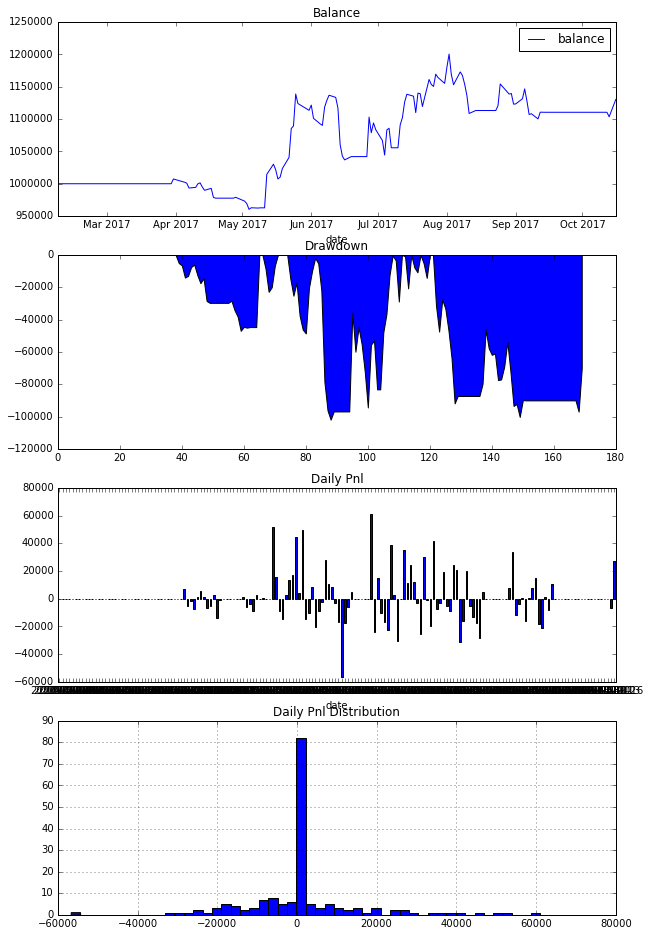

In [169]:
'''
我的回测
'''
#初始化数据需要的自然日天数
initDays = 37 #需要至少20天的交易日数据，考虑到这期间还有春节等假期因素，所以这里的自然日要多很多
#初始资金
DoubleMaStrategy.capital = 1000000

#创建回测引擎实例
engine = BacktestingEngine()

#设置引擎的回测模式为K线
engine.setBacktestingMode(engine.BAR_MODE)

#设置回测的起始日期
engine.setStartDate('20170101', initDays = initDays) #这里的initDays是真正起作用的，20天是指自然日肯定不够的

#设置产品相关参数
engine.setSlippage(0)           #滑点设置为0
engine.setRate(1.5/10000)       #股票交易手续费万1.5
engine.setSize(1)               #股票每股为1
engine.setPriceTick(0.01)      #股票最小价格变动
engine.setCapital(DoubleMaStrategy.capital) #初始资金为1

#设置使用的数据库
engine.setDatabase(DAILY_DB_NAME, vtCode)

#引擎中创建策略对象
engine.initStrategy(DoubleMaStrategy, {})

#开始跑回测
engine.runBacktesting()

#显示回测结果
engine.showDailyResult()

In [143]:
a = u'买'
if a == u'买':
    print 'yes'
else:
    print 'no'

yes
